# Credit Limit Assessment (CLA)

In [31]:
import random
from random import randrange
from datetime import datetime
from datetime import timedelta
# Работа с массивами данных
import numpy as np 
# Работа с табличными данными
import pandas as pd
# Отрисовка графиков
import matplotlib.pyplot as plt
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils
# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler
import joblib

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

#from tensorflow.keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint 

from tensorflow.keras.models import model_from_json

## Data Simulation Functions

In [32]:
def DS_ACTIVATED_CL(CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT, NUMBER_LINES):
  NUMBER_LINES = int (NUMBER_LINES)
  if CUSTOMER_TYPE == 'Business Customer Account':
    max = 1000
  else:
    max = 100

  if CUSTOMER_SUB_SEGMENT == 'Fixed & Mobile UAE':
    min = max // 2
  elif CUSTOMER_SUB_SEGMENT == 'Mobile UAE':
    min = max // 3
  elif CUSTOMER_SUB_SEGMENT == 'Fixed UAE':
    min = max // 4
  elif CUSTOMER_SUB_SEGMENT == 'Fixed & Mobile Expat':
    min = max // 5 
  else:
    min = 0
  cl = random.randint(min, max) + NUMBER_LINES * 10
  return str(cl)


In [33]:
def DS_NUMBER_LINES(CUSTOMER_TYPE):
  if CUSTOMER_TYPE == 'Business Customer Account':
    max = 300
  else:
    max = 10
  min = 0
  n_lines = random.randint(min, max)
  return str(n_lines)  


In [34]:
def DS_CUSTOMER_TYPE():
  DS_LIST = ['Residential Customer Account', 'Business Customer Account']
  return random.sample(DS_LIST, 1)[0]
# DS_CUSTOMER_TYPE()

In [35]:
def DS_CUSTOMER_SUB_SEGMENT():
  DS_LIST = ['Fixed & Mobile Expat', 'Mobile Expat', 'Fixed Expat', 'Fixed & Mobile UAE', 'Mobile UAE', 'Fixed UAE']
  return random.sample(DS_LIST, 1)[0]
# DS_CUSTOMER_SUB_SEGMENT()

In [36]:
def head_line():
  return 'ACTIVATED_CL,NUMBER_LINES,CUSTOMER_TYPE,CUSTOMER_SUB_SEGMENT'

In [37]:
def df_lines(num_lines):
  myfile = open('CLA_001.csv', 'w')
  df_str = '' + head_line() + '\n'
  myfile.writelines(df_str)
  for _ in range(num_lines):
    CUSTOMER_TYPE = DS_CUSTOMER_TYPE()
    CUSTOMER_SUB_SEGMENT = DS_CUSTOMER_SUB_SEGMENT()
    NUMBER_LINES = DS_NUMBER_LINES(CUSTOMER_TYPE)
    ACTIVATED_CL = DS_ACTIVATED_CL(CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT, NUMBER_LINES)

    df_str = '' + ACTIVATED_CL \
      + ',' + NUMBER_LINES \
      + ',' + CUSTOMER_TYPE \
      + ',' + CUSTOMER_SUB_SEGMENT \
      + '\n'
    myfile.writelines(df_str)
  myfile.close()

##DF Simulation

In [38]:
df_str = df_lines(300000)

## DF

In [39]:
df = pd.read_csv('/content/CLA_001.csv')# Это то, куда вы скачали файл
# Количество и критерии
print(df.shape)

(300000, 4)


In [40]:
df.head()

,ACTIVATED_CL,NUMBER_LINES,CUSTOMER_TYPE,CUSTOMER_SUB_SEGMENT
0,140,7,Residential Customer Account,Fixed & Mobile UAE
1,1528,114,Business Customer Account,Fixed UAE
2,651,29,Business Customer Account,Fixed UAE
3,2303,143,Business Customer Account,Fixed & Mobile UAE
4,2090,109,Business Customer Account,Mobile UAE


In [41]:
print(df.columns) #Показываем имена колонок данных

Index(['ACTIVATED_CL', 'NUMBER_LINES', 'CUSTOMER_TYPE',
       'CUSTOMER_SUB_SEGMENT'],
      dtype='object')


In [42]:
df.dtypes

ACTIVATED_CL             int64
NUMBER_LINES             int64
CUSTOMER_TYPE           object
CUSTOMER_SUB_SEGMENT    object
dtype: object

In [43]:
# max value in NUMBER_LINES
MAX_NUMBER_LINES = df['NUMBER_LINES'].max()
print(f'MAX_NUMBER_LINES={MAX_NUMBER_LINES}')

MAX_NUMBER_LINES=300


## Преобразование DF

In [44]:
# Настройка номеров столбцов
# Дальнейшие вычисления не будут зависеть от порядка столбцов в таблице

COL_ACTIVATED_CL         = df.columns.get_loc('ACTIVATED_CL')
COL_NUMBER_LINES         = df.columns.get_loc('NUMBER_LINES')
COL_CUSTOMER_TYPE        = df.columns.get_loc('CUSTOMER_TYPE')
COL_CUSTOMER_SUB_SEGMENT = df.columns.get_loc('CUSTOMER_SUB_SEGMENT')

In [45]:
# Классы CUSTOMER_TYPE
CUSTOMER_TYPE_class = [0, 
                    {'Business Customer Account	'   : 0,
                     'Residential Customer Account' : 1
                    }]
# Классы CUSTOMER_SUB_SEGMENT
CUSTOMER_SUB_SEGMENT_class = [0, 
              {'Fixed & Mobile Expat' : 0,
               'Mobile Expat'         : 1,
               'Fixed Expat'          : 2,
               'Fixed & Mobile UAE'   : 3,
               'Mobile UAE'           : 4,
               'Fixed UAE'            : 5
                             }]

In [46]:
# Вычисление счетчиков для данных разбиения
for class_desc in [CUSTOMER_TYPE_class,
                   CUSTOMER_SUB_SEGMENT_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [47]:
CUSTOMER_SUB_SEGMENT_class

[6,
 {'Fixed & Mobile Expat': 0,
  'Mobile Expat': 1,
  'Fixed Expat': 2,
  'Fixed & Mobile UAE': 3,
  'Mobile UAE': 4,
  'Fixed UAE': 5}]

In [48]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)
    
    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
      # print(f'value={value} cls={cls}')
      if value == arg:
          result[cls] = 1.

    return result

def extract_CUSTOMER_SUB_SEGMENT_to_multi(arg):
  return str_to_multi(arg, CUSTOMER_SUB_SEGMENT_class)

def extract_CUSTOMER_TYPE_to_multi(arg):
  return str_to_multi(arg, CUSTOMER_TYPE_class)

In [49]:
CUSTOMER_SS = 'Fixed & Mobile UAE'
extract_CUSTOMER_SUB_SEGMENT_to_multi(CUSTOMER_SS)

array([0., 0., 0., 1., 0., 0.])

In [50]:
CUSTOMER_TYPE = 'Residential Customer Account'
extract_CUSTOMER_TYPE_to_multi(CUSTOMER_TYPE)

array([0., 1.])

In [51]:
def extract_NUMBER_LINES_Category(arg, MAX_NUMBER_LINES):
  NUMBER_LINES = utils.to_categorical(arg, MAX_NUMBER_LINES+1) #Превращаем в категорию
  return NUMBER_LINES

# extract_NUMBER_LINES_Category(1,10)

In [52]:
def extract_row_data(row):
  ACTIVATED_CL = int(row[COL_ACTIVATED_CL])
  ACTIVATED_CL_vec = np.array([ACTIVATED_CL])

  NUMBER_LINES = int(row[COL_NUMBER_LINES])
  # NUMBER_LINES_vec = np.array([NUMBER_LINES])
  NUMBER_LINES_vec = extract_NUMBER_LINES_Category(NUMBER_LINES, MAX_NUMBER_LINES)
  
  CUSTOMER_TYPE_ohe = extract_CUSTOMER_TYPE_to_multi(row[COL_CUSTOMER_TYPE])
  CUSTOMER_SUB_SEGMENT_ohe = extract_CUSTOMER_SUB_SEGMENT_to_multi(row[COL_CUSTOMER_SUB_SEGMENT])

  # Объединение всех входных данных в один общий вектор
  x_data = np.hstack([NUMBER_LINES_vec, 
                      CUSTOMER_TYPE_ohe,
                      CUSTOMER_SUB_SEGMENT_ohe])
    
  # Возврат входных данных и выходных (зарплаты)
  return x_data, ACTIVATED_CL_vec

  # Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []
    
    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)


In [53]:
# Формирование выборки из загруженного набора данных    
x_train, y_train = construct_train_data(df.values)

In [54]:
# Для нормализации данных используется готовый инструмент
y_scaler = StandardScaler()

# Нормализация выходных данных по стандартному нормальному распределению
y_train_scaler = y_scaler.fit_transform(y_train)

In [55]:
joblib.dump(y_scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

In [56]:
# Проверка нормализации
print(y_train.shape)
print(f'Оригинальное значение CL:  {y_train [1, 0]}')
print(f'Нормированное значение CL: {y_train_scaler [1, 0]}')

# Вывод границ ненормализованных и нормализованных данных
print(y_train_scaler.mean(), y_train_scaler.std())
print(y_train.mean(), y_train.std())

(299947, 1)
Оригинальное значение CL:  1528
Нормированное значение CL: 0.355188607229962
-8.665415314740426e-17 1.0
1107.377853420771 1184.221954244447


In [57]:
# Далее используем только нормализовннаые данные
y_train = y_train_scaler 
# В итоге мы получаем следующие наборы данных:
print(x_train.shape) 
print(y_train.shape)
print(type(x_train), type(y_train))

# Пример обработанных данных
n = 0 
print(x_train[n])
print(y_train[n])

(299947, 309)
(299947, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0

## Обучение модели

In [58]:
# Функция отрисовки графика истории обучения
def plot_history(history):
    plt.plot(history.history['mae'], 
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'], 
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

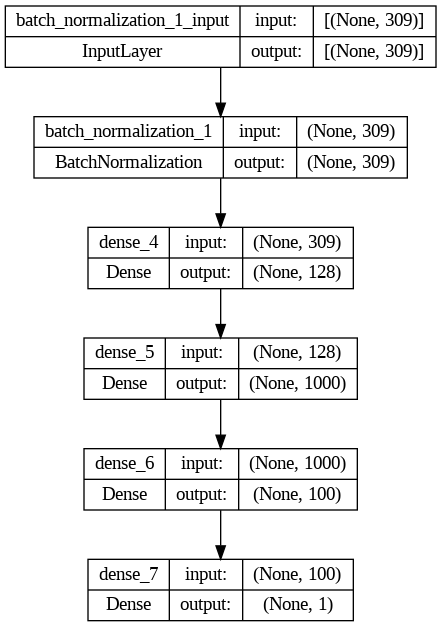

In [59]:
# Обучение модели на простых данных с нормализованной зарплатой
model = Sequential()
model.add(BatchNormalization(input_dim=x_train.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

utils.plot_model(model, show_shapes=True)

Epoch 1/50
996/996 [==============================] - 7s 4ms/step - loss: 0.2639 - mae: 0.3849 - val_loss: 0.0880 - val_mae: 0.1953
Epoch 2/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0491 - mae: 0.1551 - val_loss: 0.0937 - val_mae: 0.1968
Epoch 3/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0378 - mae: 0.1366 - val_loss: 0.0950 - val_mae: 0.1941
Epoch 4/50
996/996 [==============================] - 4s 4ms/step - loss: 0.0348 - mae: 0.1306 - val_loss: 0.0802 - val_mae: 0.1794
Epoch 5/50
996/996 [==============================] - 4s 4ms/step - loss: 0.0331 - mae: 0.1273 - val_loss: 0.0780 - val_mae: 0.1764
Epoch 6/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0314 - mae: 0.1239 - val_loss: 0.0627 - val_mae: 0.1641
Epoch 7/50
996/996 [==============================] - 4s 4ms/step - loss: 0.0302 - mae: 0.1214 - val_loss: 0.0625 - val_mae: 0.1624
Epoch 8/50
996/996 [==============================] - 5s 5ms/step - loss: 0.

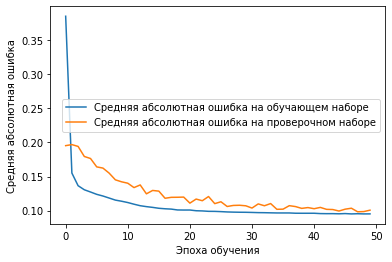

In [60]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=256,
                    validation_split=0.15, 
                    verbose=1)

plot_history(history)

In [ ]:
# Проверка работы сети - предсказание на тренировочной выборке
pred = model.predict(x_train)

# Расчет среднего значения ошибки 
print((abs(pred - y_train)).mean())         # Расчет вручную
print(mean_absolute_error(pred, y_train))   # Расчет с помощью готовой функции

9374/9374 [==============================] - 16s 2ms/step


In [ ]:
# Сохраняем саму модель
# Сериализация в JSON
model_json = model.to_json()
with open("/content/model.json", "w") as json_file:
    json_file.write(model_json)
# Сохраняем(сериализуем) веса  в формате HDF5
model.save_weights("/content/model.h5")
print("Сохранено")

In [ ]:
# Открываем json файл разметки модели
json_file = open('/content/model.json','r') 
loaded_model_json = json_file.read() # считываем
json_file.close() # закрываем
loaded_model = model_from_json(loaded_model_json) # используем керас, чтобы считать разметку архитектуры
loaded_model.summary()
loaded_model.load_weights("/content/model.h5") # подгружаем веса
print("Загружено с диска")

In [ ]:
def data_preparation(NUMBER_LINES, CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT):
  NUMBER_LINES_vec = extract_NUMBER_LINES_Category(NUMBER_LINES, MAX_NUMBER_LINES)
  CUSTOMER_TYPE_ohe = extract_CUSTOMER_TYPE_to_multi(CUSTOMER_TYPE)
  CUSTOMER_SUB_SEGMENT_ohe = extract_CUSTOMER_SUB_SEGMENT_to_multi(CUSTOMER_SUB_SEGMENT)
  x_data = np.hstack([NUMBER_LINES_vec, 
                        CUSTOMER_TYPE_ohe,
                        CUSTOMER_SUB_SEGMENT_ohe])
  # print(type(x_data))
  # print(x_data.shape)
  x_data = x_data.reshape(1, x_data.shape[0])
  # print(type(x_data))
  # print(x_data.shape)
  return x_data

In [ ]:
NUMBER_LINES = 10
CUSTOMER_TYPE = 'Residential Customer Account'
CUSTOMER_SUB_SEGMENT = 'Fixed UAE'

x_data = data_preparation(NUMBER_LINES, CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT)
pred = loaded_model.predict(x_data)             # Предсказание на тренировочной выборке
# print(type(pred))
# print(pred.shape)
pred = y_scaler.inverse_transform(pred)
cla = int(pred[0][0])
print (cla)

In [ ]:
NUMBER_LINES = 100
CUSTOMER_TYPE = 'Business Customer Account'
CUSTOMER_SUB_SEGMENT = 'Fixed UAE'

x_data = data_preparation(NUMBER_LINES, CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT)
pred = loaded_model.predict(x_data)             # Предсказание на тренировочной выборке
# print(type(pred))
# print(pred.shape)
pred = y_scaler.inverse_transform(pred)
cla = int(pred[0][0])
print (cla)